# Practical Machine Learning with SDSS Data

In this tutorial, we are going to use SDSS data to get some hands-on experience with machine learning. 

As a note in advance: none of the results you'll get out of this are science-worthy. This tutorial is meant to give you a first idea for how to set up your own machine learning model. But the first, and most important lesson, is this: **don't blindly trust your ML results.** 
As with any other science project, reporting or using results from a machine learning classifier or regressor requires careful understanding of the biases and caveats, assumptions and limitations that come with the data and algorithms chosen. Because the data sets you'll be using come straight out of the SDSS catalogue, you can expect there to be funny effects (both subtle and not) that may mess up any classification you'd want to do, and in a real-world setting, this would include understanding the limitations of the instrument and the data processing, before drawing any scientific conclusions from your procedure.

With that out of the way, let's have some fun with machine learning! In this tutorial, we will use python and a library called `scikit-learn` to do our machine learning, `pandas` to deal with data structures, and `matplotlib` and `seaborn` to do our plotting. 

### Imports + Packages

You might not have all the packages you need in order to follow this notebook. If you don't, here's some code that might help you install it. If you don't use `pip` to manage your packages (e.g. because you use Anaconda), you might want to do this in a command line instead, and then restart the notebook.

If you're working in Colab, definitely remove the commenting.

In [ ]:
#!pip install seaborn
#!pip install sklearn

In [1]:
# make plots interactive and import plotting functionality
%matplotlib notebook
import matplotlib.pyplot as plt

# pretty plotting
import seaborn as sns

# my standard styles for plots|
sns.set_style("whitegrid")
sns.set_context("talk")

# Always need numpy
import numpy as np

# data array operations
import pandas as pd

### Load the Data

Our first task is loading the data. Every one of you should be assigned to a group, and each group should have been assigned a data set. Your task is to find the correct file in this folder and load the data into a `pandas.DataFrame` (if you've never worked with pandas, take a look at the `read_csv` function).

If you're in Colab, you'll want to clone the github repo and move into it in order to load the data:

In [ ]:
#!git clone https://github.com/dhuppenkothen/cargese2018_tutorials.git
#%cd cargese2018_tutorials/tutorial1/

In [4]:
# add your code for loading the data here:
data = pd.read_csv("sdss_dataset4.csv", index_col=0)

The `head` method on your loaded `DataFrame` gives you a quick overview of what's in your data:

In [5]:
data.head()

,objid,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,mag_u,mag_g,...,u_g_color,g_r_color,r_i_color,i_z_color,class,diff_u,diff_g,diff_r,diff_i,diff_z
200453,1237667255089627310,185.21386,30.640840,21.34636,19.94760,19.76113,19.70567,19.59102,21.32034,19.96796,...,1.398762,0.186472,0.055462,0.114645,b'QSO',0.02602,-0.02036,-0.00039,0.00370,-0.01339
200454,1237667255089627432,185.16828,30.834921,21.38283,20.83205,20.66901,20.60667,20.41871,21.33970,20.81803,...,0.550781,0.163032,0.062344,0.187962,b'QSO',0.04313,0.01402,0.00058,0.02277,0.00790
200455,1237667255626563932,185.29559,31.223772,22.96750,21.57093,21.62768,21.81227,21.66042,22.78687,21.61073,...,1.396570,-0.056749,-0.184595,0.151856,b'QSO',0.18063,-0.03980,-0.09919,-0.09054,-0.02286
200456,1237665328778707278,185.18881,31.380240,22.77770,21.99095,21.93793,21.88836,21.48611,22.47358,21.97662,...,0.786755,0.053020,0.049562,0.402254,b'QSO',0.30412,0.01433,0.01842,0.00850,0.04942
200457,1237665328778641516,185.06548,31.320324,19.88215,19.07281,19.09246,19.07664,18.91570,19.87109,19.08928,...,0.809347,-0.019659,0.015829,0.160933,b'QSO',0.01106,-0.01647,-0.00465,-0.01189,-0.01113


Where you go from here depends on which data set you've downloaded. Specifically, for some data sets, you'll have to pull out the *classes* you want to classify, for others the continuous quantity you want to predict.

Classification
- `sdss_dataset1.csv`: extract the `class` column

Regression
- `sdss_dataset[2:9].csv`: extract the `spec_z` column

**Note**: Don't forget to remove the column with your classes/regression variable from the DataFrame, otherwise you'll use the thing you want to find as a feature, which makes your ML performance *really* good, but also *really* wrong! Take a look at the `drop` method for DataFrames to help you achieve that.

Many of the steps are the same, so just follow along the following exercise for both!

Some quick lingo: In machine learning, the things we are trying to learn are often called **labels**, and the quantities we can use to learn them are **features**. For example, in some of the data sets, you're going to try and separate stars and galaxies by their magnitudes and colours. Here, for each **sample** in your data set, you have a bunch of magnitude and colour measurements, your features, and you're trying to predict whether that sample is a galaxy or a star, its label. For the photometric redshift estimation case, you similarly have magnitudes and colours as features, and you're trying to predict the redshifts (your labels). This is called **supervised learning**. 

Note that in this case, we always need examples where we *know* the ground truth: we need to know the class really well, or we need to know the redshift beyond a reasonable doubt (in our case here e.g. through precise spectroscopic measurements). This is often not the case in astronomy (or, indeed, science): we often don't know exactly what our labels should be. In these cases, **unsupervised learning** can be really helpful. Some of you have data sets without labels. You'll be playing around with clustering algorithms.

In [47]:
# extract the column you want to predict in a variable called `labels`
specz = data["spec_z"]

# drop that column from the rest of the table 
features = data.drop(["spec_z", "class"], axis=1)

### Building a first classifier

Let's start by building a first, simple classifier/regressor. Normally, you wouldn't *start* by doing a classification, but for most of your data sets, there are some points we're going to make throughout this tutorial, so having a classification without knowing much about the data serves as a useful baseline. In general, though, running an ML algorithm comes at the end of *many* important steps, which is part of the point of this entire tutorial.

We're going to start working with the [k-nearest neighbour algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). This is one of the simplest machine learning algorithms out there. Essentially, it takes the $k$ nearest neighbours of a given sample and uses these neighbours to give an estimate of what the label for that sample should be. For the classification rpoblem, it assigns the majority vote of neighbour labels, for regression it assigns the average of the values of its $k$ nearest neighbours.

In `scikit-learn`, these live in `sklearn.neighbors` as [`KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) and [`KNeighborsRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor). The unsupervised equivalent is in [`NearestNeighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors).

Try it out! Don't worry about the parameters right now, we'll do that further down below. 

**Hint**: Basically all algorithms implemented in scikit-learn have the same interface. Basically all of them have a `fit` method that will fit your data, a `predict` method that will predict the classes/values of new samples, and a `score` method that tells you something about how good your algorithm is at making predictions. Some algorithms also have a `transform` and a `fit_transform` method, which allows you to transform your features (e.g. dimensionality reduction algorithms like Principal Component Analysis). Many machine learning libraries outside of scikit-learn have adopted the same structure, which is super helpful when using these libraries for algorithms that are not implemented in scikit-learn. Learning how to do a workflow in scikit-learn is well worth the investment.

In [10]:
# import the correct class for your problem and
from sklearn.neighbors import KNeighborsRegressor

# general way to work with scikit-learn algorithms:
# >>> my_clf = NameOfClass(set_parameters_here)
# >>> my_clf.fit(features, labels)
# >>> predicted_labels = my_clf.predict(features)
# >>> score = my_clf.score(features, labels)
# some methods (like PCA) allow transformation of the data
# they also have a `fit_transform` method:
# >>> transformed_features = my_clf.fit_transform(features)

# now instantiate your KNN classifier and fit the features 
# and labels we've just extracted

kn = KNeighborsRegressor()
kn.fit(features, specz)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

Let's *score* the model's performance. For most methods in scikit-learn, the `score` method calculates the *accuracy* of the predictions. That is, it uses the trained model to calculate predictions for all samples, and then counts all samples for which it predicted the right thing, and divides that by all samples. So the accuracy is the *fraction of samples where the algorithm predicted the correct number*. 

In [11]:
# calculate the score for your data
kn.score(features, specz)

0.23395410590023727

What score did you get?

**Exercise**: Do you trust this score? Why? Why not? Discuss with your group! Are there ways you could make your score more trustworthy? 

## Training, Validation and Test Sets

Ok, so, are we done now? Obviously not, or this tutorial would be pretty short. :)
You hopefully just got a super high score on your classification/regression, but is this number actually useful? The answer is both yes and no. You just **trained** your data on a data set, but you also **tested** the model's performance on the *same* data. As a baseline, it's useful to know how well your algorithm does on the training data. In a simple example, imagine the quantity you're trying to predict lies on a parabola, but you're fitting a straight line to it. Even for your training data, the performance won't be great, because no matter what you do, your straight line won't do a good job of representing a parabola. 

But there is another problem here. Your performance on the same data you used to train your algorithm won't tell you anything about how well your algorithm generalizes to **new** examples, which is what we ultimately care about. It is easy, especially for some of the more complex algorithms, to make an arbitrarily complicated function that will reproduce the training data really well, but because it's so specifically trained on a specific data set, it'll do horribly on new examples. This is often called **overfitting**.

What we really need is some data we've never seen before, but for which we know what the output should be. In machine learning, it is standard to separate out a **test set**, i.e. part of the data for which you know the answer, but which you will not look at *until the very end*.

**Exercise**: So let's divide our data into a training and a test set. Discuss with your team what fraction of your data is appropriate to have in your training and your test set.

**Note**: For the regression data sets, I have helpfully saved a test set for you in a different file which you'll look at later. You'll need this to compare your results with other groups. 

In [15]:
# split your existing array of features and labels into a training and a test set
n_train = int(0.75*len(features))

f_train = features[:n_train]
l_train = specz[:n_train]

f_test = features[n_train:]
l_test = specz[n_train:]

Now run your ML algorithm again, but use the *test data* in the score method (again, this is normally something you want to wait with until the *very end*, but there's going to be a point to this, I promise!):

In [17]:
# set up and train your algorithm as above, but only on the training data and labels
kn = KNeighborsRegressor()
kn.fit(f_train, l_train)
kn.score(f_train, l_train)

0.24001904435236032

In [18]:
# now compute and print the score for both the training and the test data
kn.score(f_test, l_test)

-0.17205060483426005

**Discuss**: Is this a good score? How well do the training and the test scores match? Are we done *now*? How could we figure out whether this is a good result or not?

No, of course we're not done. We haven't even really looked at our data yet! Some of you will have gotten a really great score, some of you won't. However, **a good score does not necessarily mean that you have a good, reliable model**. In machine learning applications, papers will often cite accuracy (or similar scores) as evidence that their model performs well. And this is true, but only for a limited number of circumstances. What's really important to know is how a model fails, and why it fails. A model with a high accuracy is still really *biased*, for example if it gets all redshifts in a certain part of parameter space wrong, or if it mis-classifies all stars as galaxies. Any conclusions we draw based on those classifications will be biased, too (for example, we might conclude there are no stars, because our algorithm didn't find some, and that would be really hard to explain in reality, seeing as the sun exists).  

**Exercise**: It's time to look at your data! Plot some of the columns in your data, and especially look at your predictions for the test set: where did the model do well? Where did it crash and burn? Are there any systematic trends in how it failed? Do you have any ideas for how you could fix your model or procedure? Note down your conclusions to share with the group later!

In [ ]:
# use these cells (feel free to make more, of course) to explore the data and your 
# first classifier: where did it succeed? Where did it fail? 

In [19]:
pred_z = kn.predict(f_test)

In [22]:
f_train.columns

Index(['objid', 'ra', 'dec', 'dered_u', 'dered_g', 'dered_r', 'dered_i',
       'dered_z', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'u_g_color',
       'g_r_color', 'r_i_color', 'i_z_color', 'diff_u', 'diff_g', 'diff_r',
       'diff_i', 'diff_z'],
      dtype='object')

Here's a plot of one particular magnitude (in r-band) versus the difference of the predicted and true redshifts. 

<IPython.core.display.Javascript object>


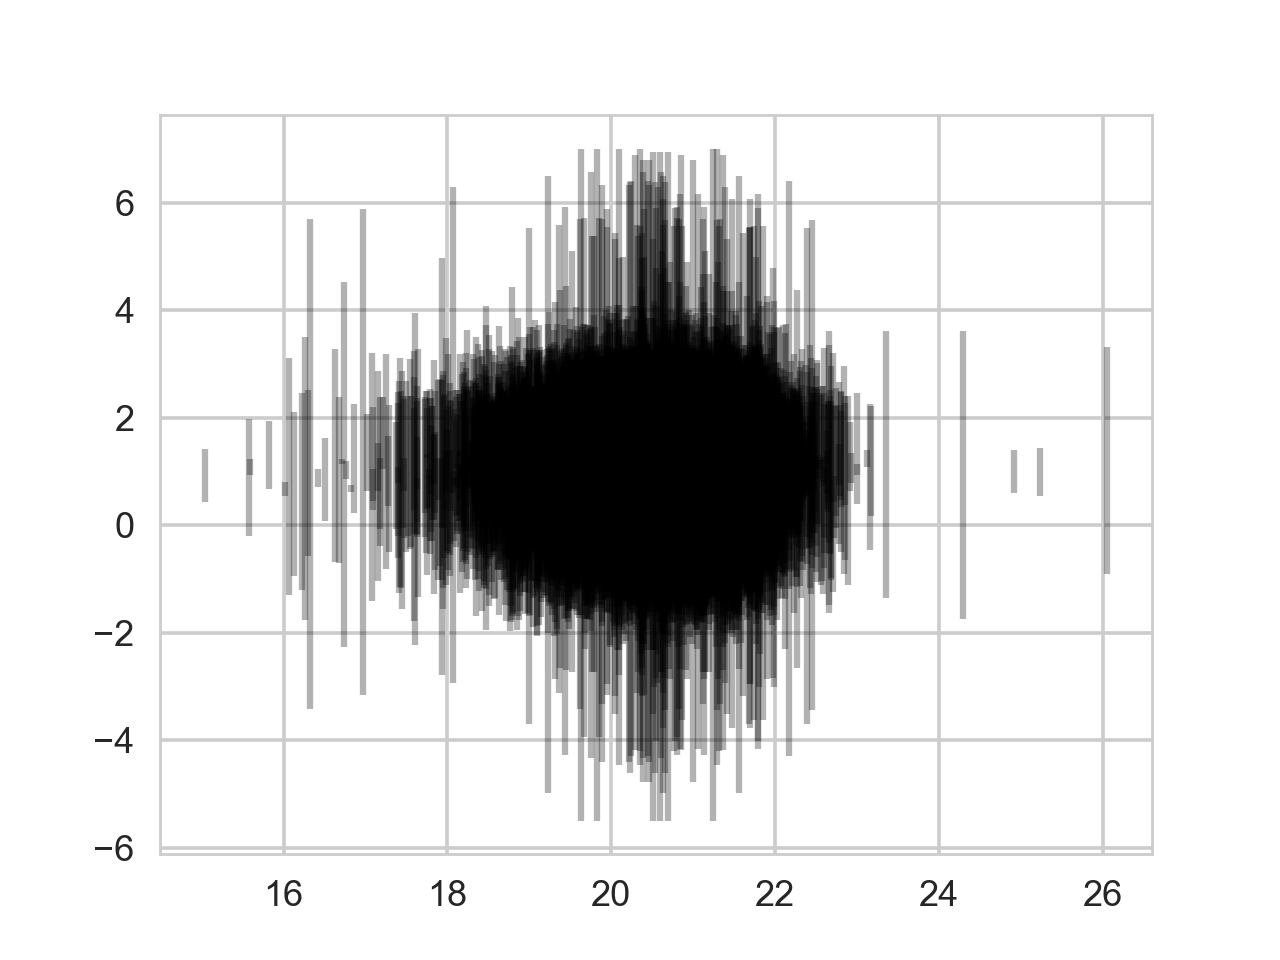

In [24]:
plt.figure()
plt.vlines(f_train["dered_r"], l_test, pred_z-l_test, alpha=0.3)

That looks pretty bad! What's the mean difference?

In [25]:
np.mean(np.abs(l_test - pred_z))

0.8359091975497364

So there's a mean difference between predicted and true redshifts of 0.83! We're not going to do cosmology with that! My guess is that this model vastly overfit the training data set, so that it doesn't generalize well to new examples.

Another often-used plot in this problem is to plot the photometric (derived) redshift versus the spectroscopic redshift. In an ideal case, the redshifts should cluster on the $f(x)=x$ line:

<IPython.core.display.Javascript object>


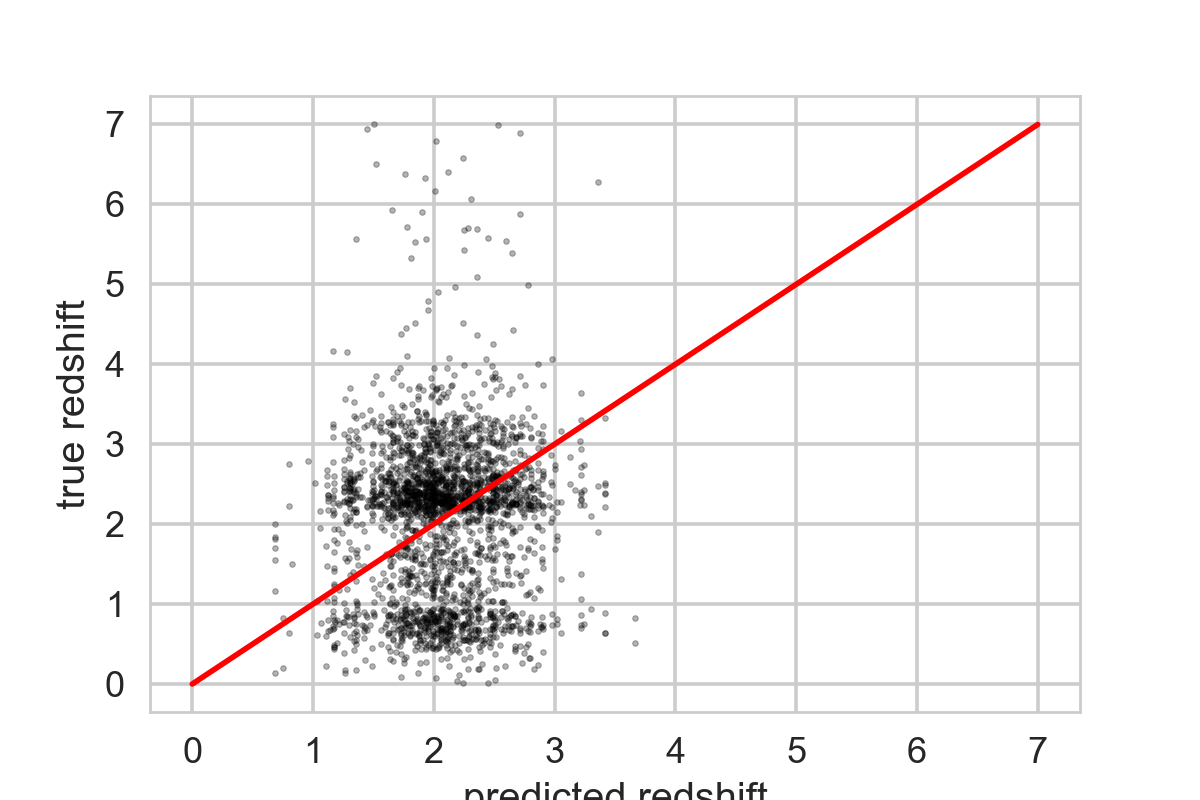

Text(0,0.5,'true redshift')

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(pred_z, l_test, s=4, color="black", alpha=0.3)

x = np.linspace(0,7,1000)
ax.plot(x, x, lw=2, color="red")

ax.set_xlabel("predicted redshift")
ax.set_ylabel("true redshift")

# Machine Learning: From Start To Finish

I set a really bad example above by (1) asking you to run the algorithm on the data before we'd even looked at it, and (2) using the test data set before we were ready. The idea was to give you an idea to explore some of the things that can go wrong with your machine learning if you're not careful. We're now going to do better, and run through a typical machine learning workflow from start to finish.


## Figuring out your goal: Asking why!

The first step in *any* research project, but certainly in any machine learning project, is to define your goal. What are you going to do with your results? Are you trying to learn something about physics with your data set? Are you just trying to separate out good signals from bad ones? 

Unfortunately, many physics questions don't necessarily easily translate to a machine learning problem (this is often true for statistics as well). Going from "I want to know what dark matter is" to "run a random forest on SDSS photometric measurements" is really hard, and requires multiple iterations of reducing your *physics* question down to one that ML or statistics (or a combination of the two) can answer. It's well worth spending significant time at this stage, because this process will give you crucial insights about every step of your analysis procedure, from which columns in your data might be useful, to which dimensionality reduction algorithms might work, to the type of appropriate ML algorithm to use. 

One important question I've already implicitly answered for you above: Do you have ground-truth labels in your training data? That is, do you have data for which you are reasonably sure that the labels assigned to each sample are correct? Another question I've already implicitly answered: Do you have a **classification** or a **regression** problem. In a classification problem, you have categorical labels (e.g. "star", "galaxy", ...) that you try to assign to new samples. In a regression context, the variable you try to assign is continuous (e.g. redshift). 

Here are some additional questions you might want to think about at the very start, but also keep in mind throughout your analysis:
* Do you only care about the *predictions*, or do I also care about the *parameters*? That is, are you trying to learn something about the structure of the problem itself (e.g. physics), or do you just care that the predictions are right?
* How well does your training data match the samples for which you don't know the labels? Are they from the same survey/instrument? Are there significant differences between the data you can train on, and the data you want to classify? 
* What biases do you already know if in your training data? Is your survey flux-limited? Did the team making the catalogue only care about a particular funny type of Cataclysmic Variable and leave out another you might be interested in? Is there a part of feature space that's just not covered? 
* What physical knowledge do you have about your measurements? How can that physics knowledge guide you in selecting or constructing good features? 



## Feature Selection and Engineering

One of the crucial parts of machine learning, and the part that you will likely spend most of the time on, is selecting and engineering features for training on. Features are, essentially, meaningful summaries of your data that are ideally designed such that they make classification and regression easy. In terms of the problems you're considering today, notice that the magnitudes we've extracted from the SDSS catalogue are not actual data. They're measurements derived from the *images* that the telescope took. 

There are machine learning algorithms that can take raw data, e.g. the pixel values in an image. The most popular type used especially in image recognition in recent years is the Convolutional Neural Network (CNN), which takes raw data and essentially internally learns what good representations of the data are.

CNNs have been enormously successful for a whole number of tasks, but it's worth pointing out that they're not always the ideal solution. They're big and very, very expensive to train (some of them can take weeks even on supercomputers!). If you have knowledge about the structure of your data and your problem, then it may be more efficient and reliable to use that knowledge to extract meaningful features. For example, we know that photons hit a CCD following a point spread function (PSF). We might not know that PSF very well, but if we do, there's no point making a neural network *learn* that a PSF exists; we can just extract magnitudes and work with them directly. So for any ML problem, it's worth thinking about what you know, and what you don't know. In cases where you *don't* know your PSF very well (or any number of things that may affect your measurements), it might be worth having your model learn that structure, but just take note that that's not universally true.

Let's now turn to the data you extracted. 

In any data set, you might have columns that are more useful than others! Let's find the ones we want to use for classification!

**Exercise**: Print the columns in your features table. What columns are there in your table? Are all of them useful for solving your problem? Discuss with your team which ones might be useful, and which ones might not be! Reminder: you can look up what some of those columns mean [here](http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+SpecPhoto+V). 

In [48]:
# list all columns in the table
features.columns

Index(['objid', 'ra', 'dec', 'dered_u', 'dered_g', 'dered_r', 'dered_i',
       'dered_z', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'u_g_color',
       'g_r_color', 'r_i_color', 'i_z_color', 'diff_u', 'diff_g', 'diff_r',
       'diff_i', 'diff_z'],
      dtype='object')

In [49]:
# drop columns you don't think will help the classification
f_clean = features.drop(["objid", "ra", "dec", "diff_u", "diff_g", "diff_r", 
                         "diff_i", "diff_z","mag_u", "mag_g", "mag_r", 
                         "mag_i", "mag_z"], axis=1)


### Visualizing Feature Spaces

One of the most useful things you can do to star with is visualize your data! There are, of course, many different ways to visualize high-dimensional data. For example, you can make a histogram of the distributions for each feature (for classification problems, colour-coded by class works well), or you can make scatter plots or heatmaps of one feature against one another. You can also do both at the same time in what's called a *corner plot*. In python, the package `seaborn` has a lot of nice visualizations pre-built to cut down the time you need to deal with nitty-gritty details of making complicated plots work.

**Exercise**: Discuss and try out ways to visualize your features. For classification tasks, take a look at the [`pairplot`](https://seaborn.pydata.org/examples/scatterplot_matrix.html) function in seaborn. For the classification problems, look for features that separate stars and galaxies well. For the regression, try to gauge by looking at the features how complex a model you'll likely need. When you plot your features versus the redshift in `spec_z`, do the redshifts lie on straight line? Are there more complicated trends and structures in the data? 

In [50]:
# add some plots

In [51]:
f_clean.columns

Index(['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'u_g_color',
       'g_r_color', 'r_i_color', 'i_z_color'],
      dtype='object')

<IPython.core.display.Javascript object>


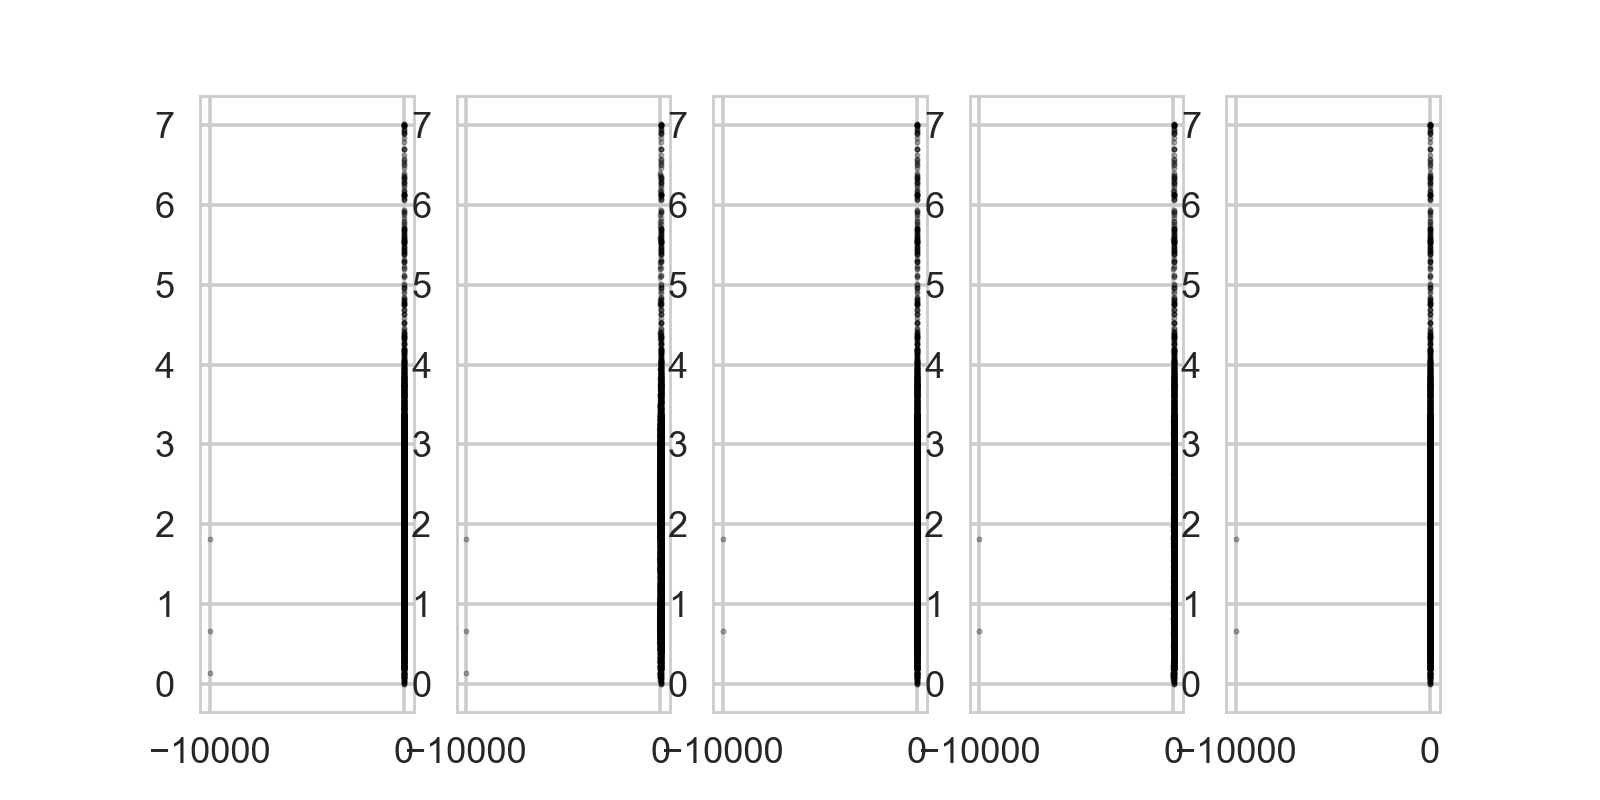

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(8,4))

labels = ['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']

for i, l in enumerate(labels):
    axes[i].scatter(f_clean[l], specz, s=3, c="black", alpha=0.3)


Okay, so there are clearly data points in there that don't make sense! Let's delete those:

In [52]:
mask = (f_clean['dered_u'] < -1000) | (f_clean['dered_g'] < -1000) | (f_clean['dered_r'] < -1000) | (f_clean['dered_i'] < -1000) | (f_clean['dered_z'] < -1000)

In [53]:
np.sum(mask)

3

So there are three data points with weird magnitudes. Let's remove them:

In [54]:
f_clean = f_clean[~mask]

In [55]:
specz = specz[~mask]

Okay, let's plot again:

<IPython.core.display.Javascript object>


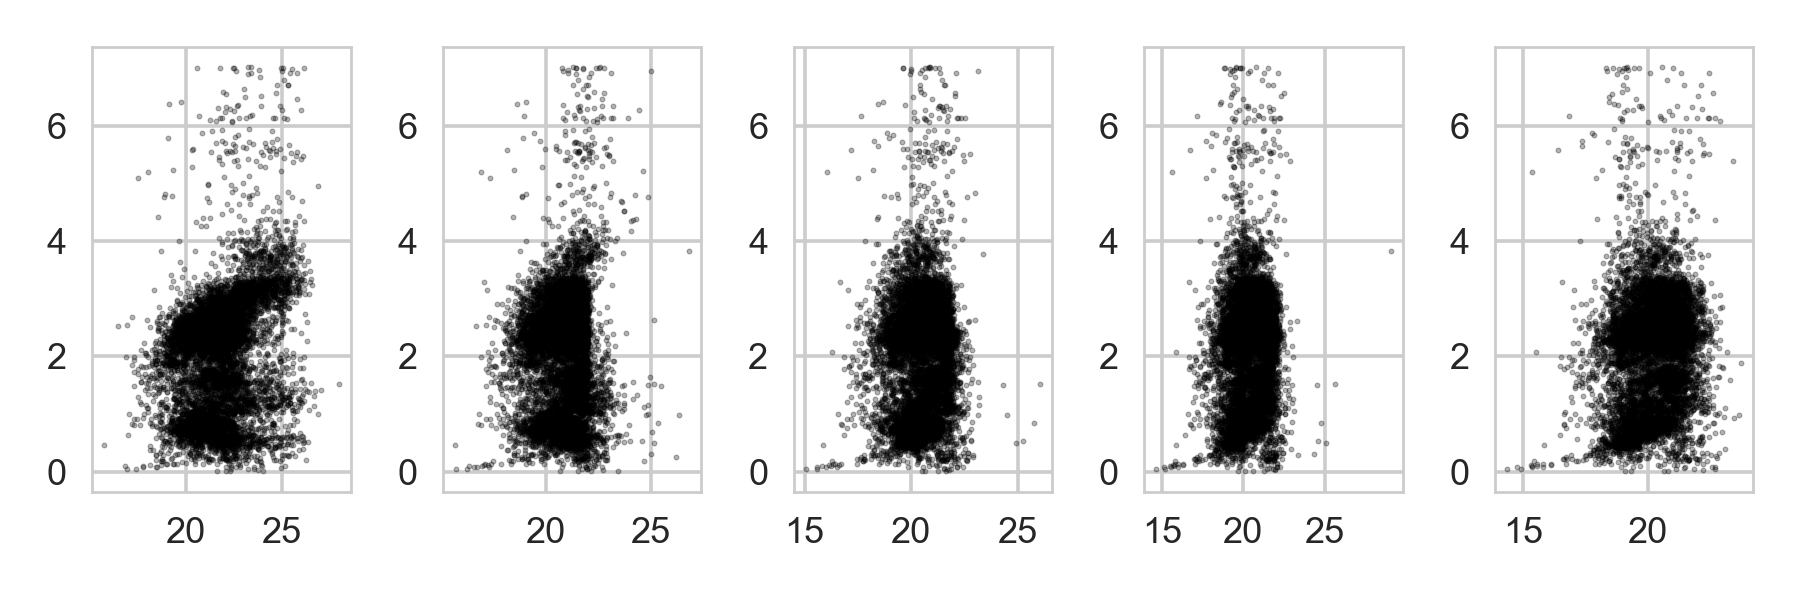

In [59]:
fig, axes = plt.subplots(1, 5, figsize=(9,3))

labels = ['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']

for i, l in enumerate(labels):
    axes[i].scatter(f_clean[l], specz, s=3, c="black", alpha=0.3)

plt.tight_layout()

<IPython.core.display.Javascript object>


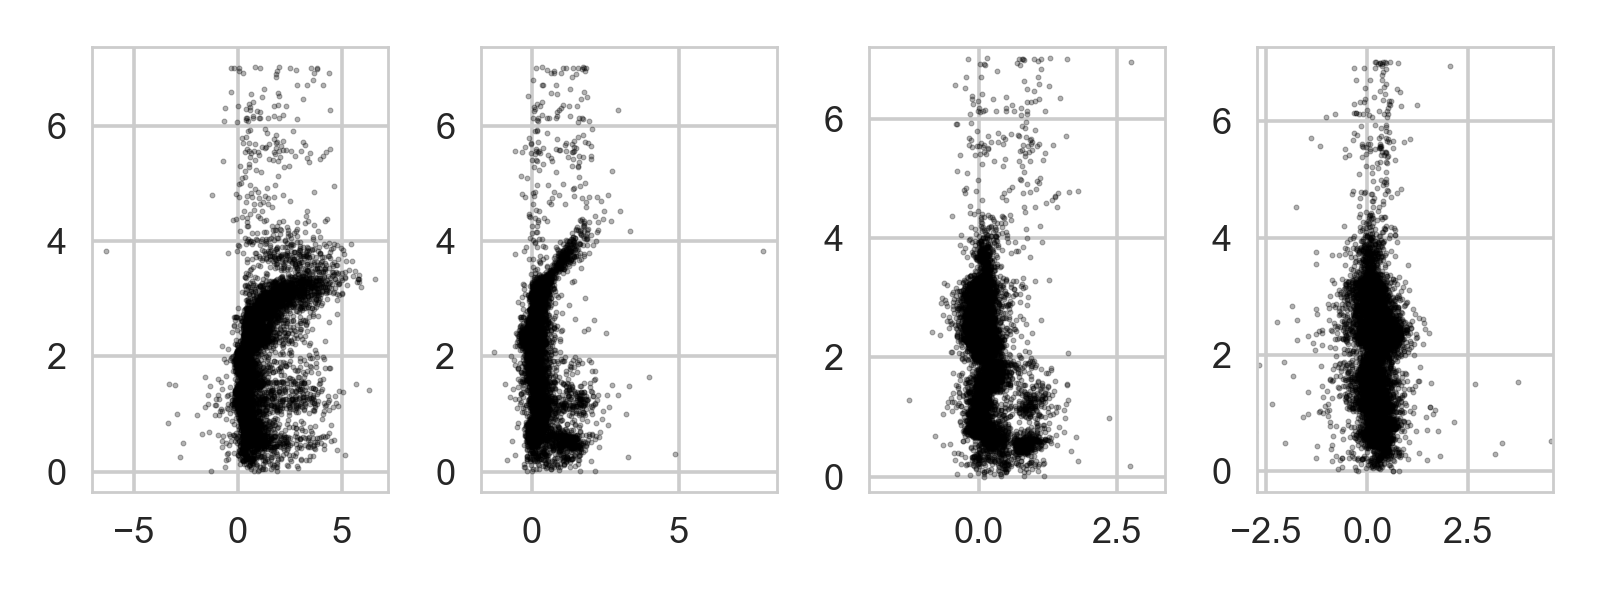

In [67]:
fig, axes = plt.subplots(1, 4, figsize=(8,3))

labels = ['u_g_color','g_r_color', 'r_i_color', 'i_z_color']

for i, l in enumerate(labels):
    axes[i].scatter(f_clean[l], specz, s=3, c="black", alpha=0.3)

plt.tight_layout()

### Looking for Weird Things

One of the key tasks during this stage of your analysis is to *sanity-check* your data. Are there weird things? Instrumental artifacts? Things that don't look right? This is where you explore your data and try to find (and explain) these things, and potentially remove them before training.

**Exercise**: Take a close look at your features. Are there features in the data that look artificial? If so, can you think of ways to remove them?

In [ ]:
# create a mask of all data points you don't think are good data points and remove them, 
# then plot again



### Dimensionality Reduction

Another way to try and make sense of high-dimensional feature spaces is to perform *dimensionality reduction*. There are a lot of different ways to reduce the dimensionality of your features, and some are more useful than others, depending on the structure of your data and your problem. One idea with dimensionality reduction is to find the combination of features that gives you the most useful information in terms of your regression or classification problem. Some other times, all you want is a handy visualization in 2D, since humans in general aren't very good at thinking in higher-dimensional spaces.

[Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is one of the most straightforward ways of reducing dimensionality (see also [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) for alternative methods implemented in scikit-learn). One useful thing to try might be to project your features into a smaller space and see whether you still capture the information relevant in order to perform a good classification or regression.

**Exercise**: Use PCA to project your features into 2 dimensions, and compare with the full data space. Do you think most of the information in your features is captured by the 2D representation? 

**Hint**: The `fit_transform` method will come in handy here.

In [60]:
from sklearn.decomposition import PCA

In [62]:
# instantiate a PCA object, then transform your features into a 2-D representation
# reminder: data transformation algorithms like PCA have a `fit_transform` method
# that might come in handy

pca = PCA(n_components=2)
f_pca = pca.fit_transform(f_clean)

<IPython.core.display.Javascript object>


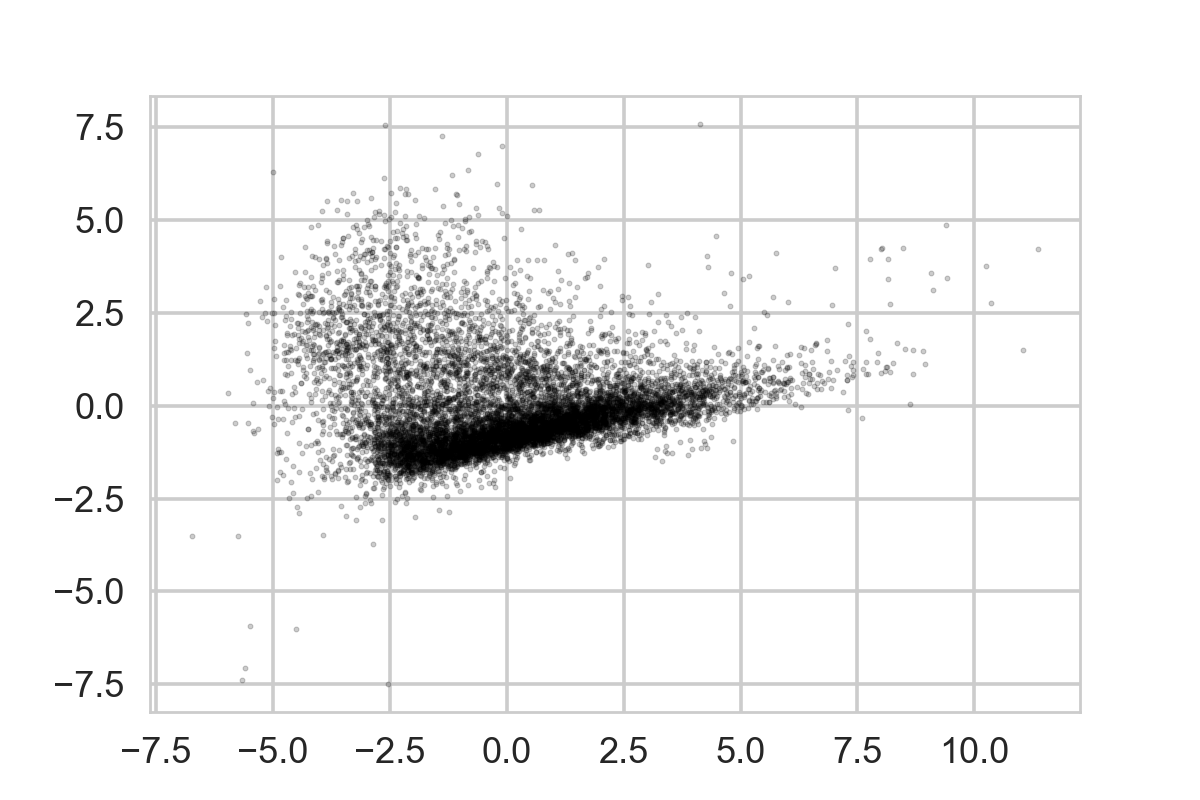

In [63]:
# plot the 2D representation of your data
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(f_pca[:,0], f_pca[:,1], s=3, c="black", alpha=0.2)

<IPython.core.display.Javascript object>


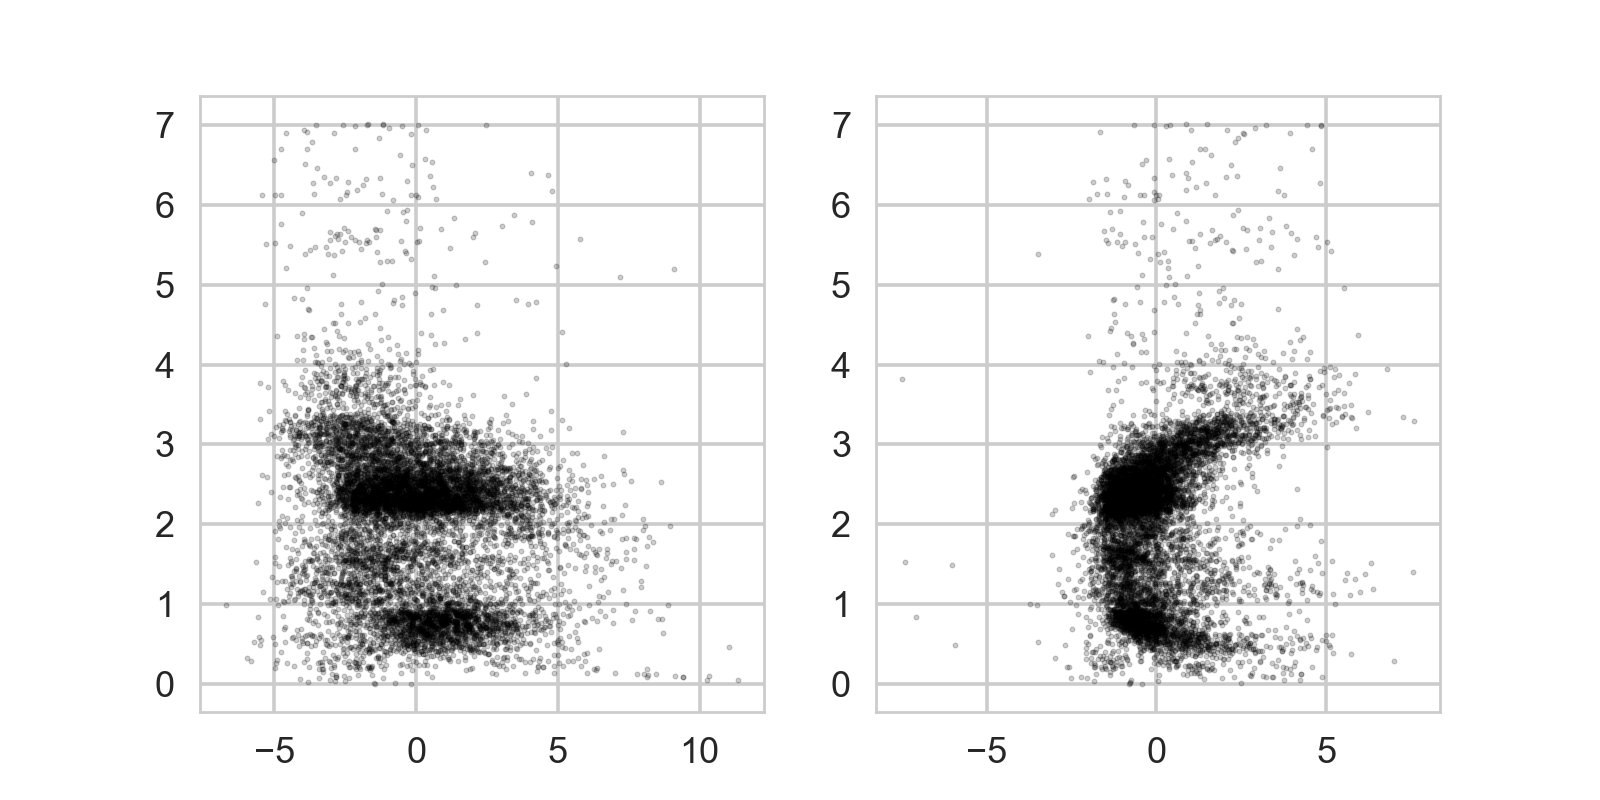

In [65]:
# plot the 2D representation of your data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.scatter(f_pca[:,0], specz, s=3, c="black", alpha=0.2)
ax2.scatter(f_pca[:,1], specz, s=3, c="black", alpha=0.2)

Another way to visualize high-dimensional data is called *t-distributed stochastic neighbour embedding*, or, for short, t-SNE. [The paper](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) is surprisingly readable for a computer science paper, and the method is generally pretty good at visualizing complex feature spaces (and you can spend some entertaining minutes letting your brain find fun things in the patterns it produces). 

One thing you have to be aware of, however, is that t-SNE *does not generalize to new examples*. Wheras methods like PCA can be trained on some data, and then the trained model applied to new samples, this is *not true* for t-SNE. So this is a method that's useful for visualization, but it doesn't necessarily produce features you want to use in your classification. Note that t-SNE is generally quite a slow algorithm, so running this on very large data sets might leave you waiting for a while!

**Exercise**: Let's try it out! Visualize your feature space in 2 dimensions using t-SNE (hint: this is also implemented in scikit-learn).

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# perform the same procedure as with PCA for t-SNE:
# instantiate a TSNE object, fit_transform your data, and plot the results

### Feature Combinations

It is possible in machine learning to *combine* features. You could add, subtract, multiply or divide one feature with another, or square a feature, or take the log, ...

In a way, we've already implicitly done this: our original measurements that were taken with the telescope are just the *magnitudes*, but our data set also contains colours: the difference between magnitudes. This choice was guided by our knowledge of how astronomical sources emit light and the kinds of spectra they make. 

**Exercise**: Do you think other combinations of features might be useful? If so, which? Do you think some features might be more useful in logarithmic space?


Answer: Probably not in this case.

### Scaling Features

Sometimes, your features vary wildly in order of magnitude. You may have photometric magnitudes that all lie between 13 and 20, but maybe you have a feature that's between 1 and 1,000,000, so that your different dimensions have vastly different scales. Some algorithms (e.g. random forests) can deal with that pretty well, but others can't. It's worth knowing enough about the algorithms you use whether they will deal with this kind of issue or not. If the method can't, one common solution is to re-scale the features such that they all have a mean of zero and a variance of one. 

Scikit-learn has a few ways of scaling features and other potentially useful steps for pre-processing data. Take a look at [this tutorial](http://scikit-learn.org/stable/modules/preprocessing.html). 

**Exercise**: Do you think scaling will help in your problem? Try scaling your features and re-running the PCA and t-SNE algorithms. Did your results change?

In [72]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# instantiate a StandardScaler object and `fit_transform` your 
# data points into a scaled version, then rerun PCA and t-SNE 
# and plot again

In [73]:
scaler = StandardScaler(with_mean=True, with_std=True)

f_scaled = scaler.fit_transform(f_clean)

<IPython.core.display.Javascript object>


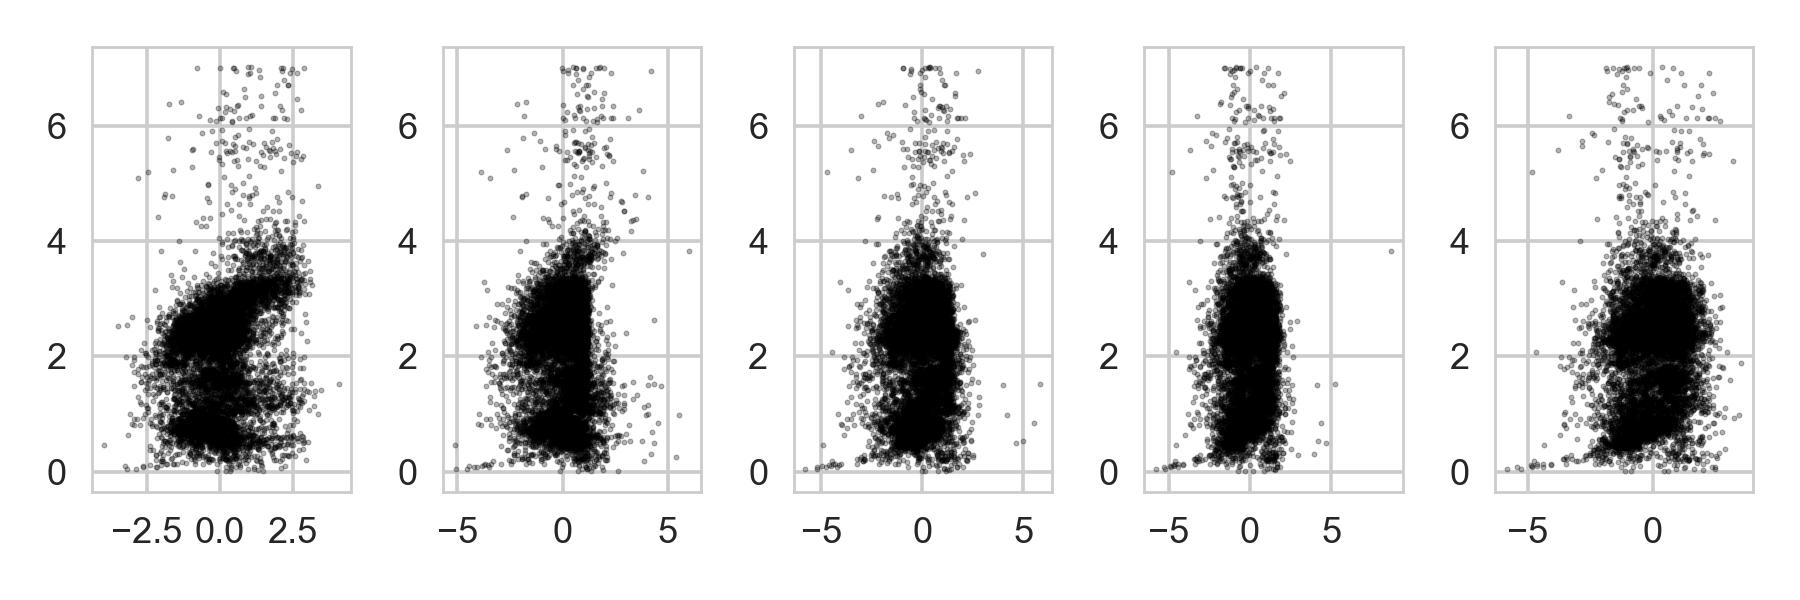

In [84]:
fig, axes = plt.subplots(1, 5, figsize=(9,3))

for i in range(5):
    axes[i].scatter(f_scaled[:,i], np.array(specz), s=3, c="black", alpha=0.3)

plt.tight_layout()

<IPython.core.display.Javascript object>


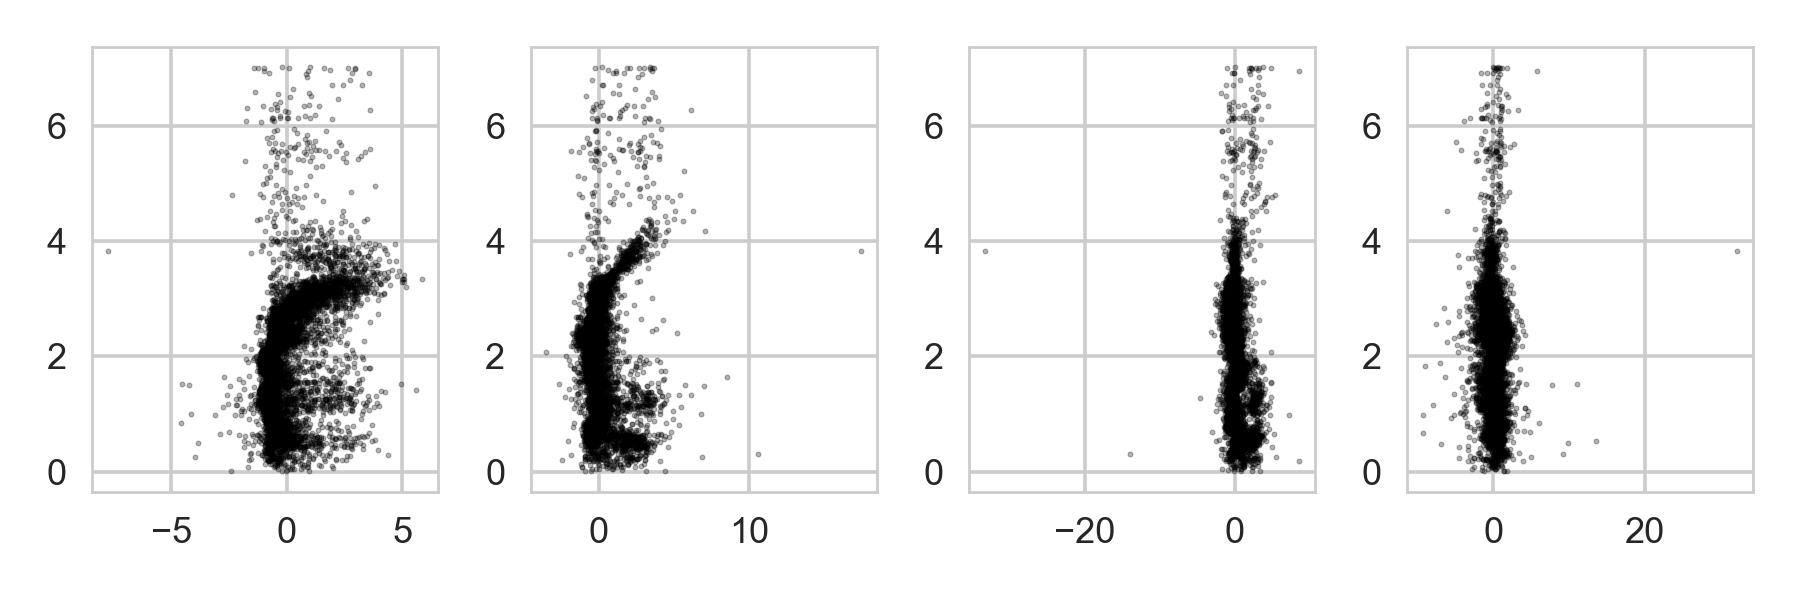

In [85]:
fig, axes = plt.subplots(1, 4, figsize=(9,3))

for i in range(4):
    axes[i].scatter(f_scaled[:,5+i], np.array(specz), s=3, c="black", alpha=0.3)

plt.tight_layout()

## Train-Test-Validation Splits

Now is the time to think about splitting your data set into trainining, test and validation test sets. As we've mentioned above, it is really important for you to hold out a *test* set, which you will *not* look at until the end of the entire analysis. 

One issue you might come across is that your data is *ordered* in some. For example, a catalogue might just happen to list their data points by Right Ascension, or perhaps even by category of object. The latter can be a problem: if your data set contains all galaxies, followed by all stars, and you split along the middle, your training data might contain predominantly galaxies, and your test set predominantly stars. 

Generally, you want to be sure that your *training* and your *test* data are **representative** of the population you are trying to model. One (simple) way to achieve this is via randomization. You can randomize the entries in your table before picking training and test sets. `scikit-learn` has a convenient function for this called [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), which by default shuffles your entries before splitting into training and test sets.

Another important thing to think about is **stratification**: if your data set is very imbalanced, randomized splitting into training and test sets can lead to all examples of the smaller class ending up in one of the two sets, but not in both. Stratified splitting uses the class labels to ensure that examples of all classes end up in the training and test sets.

**Exercise**: Split off a training and a test set. What relative sizes should your training and test sets have, do you think? What factors might determine how you make that split? Should you use a stratified split?  

**Note**: For the photometric redshift data sets, there is a separate test set in a different file, which you will look at at the very end. Still, have the discussion above and try out `train_test_split` so you'll know how it works for future applications.

In [ ]:
# use train_test_split to split off a test set for later use
# Think about whether you need to shuffle your data set (there's a keyword for that), 
# and whether you need to stratify it (there's a keyword for that, too!)

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_test, z_train, z_test = train_test_split(f_scaled, specz, train_size=0.75, shuffle=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [88]:
len(X_train)

7497

In [89]:
len(X_test)

2500

## Picking a Machine Learning Algorithm to Start With

Which machine learning algorithm you choose for your problem depends, as we've discussed above, strongly on the type of problem you're trying to solve and the structure of the data. But even once you've decided whether you have a regression or classification problem, and whether it's an unsupervised or supervised one, there remain many algorithms to choose from!

All algorithms essentially do the same thing: they draw more or less complex functions in a multi-dimensional space (the number of dimensions corresponds to your number of features). Broadly, in the regression case, these methods try to find the best function to draw *through* the data points in order to model them. In the classification case, these methods try to find a surface that *separates* the different classes from another (this is also called a decision boundary). 

One big question is how *interpretable* the model ought to be. Simpler algorithms are often easier to understand and the results more straightforward to interpret than from, say, a random forest. A general good suggestion is to start with the simplest model you think you can get away with, and only move to more complex models if your problem demands them.

Neural networks have been hugely successful in solving complex machine learning problems, in part because they can *learn* features rather than require the user to hand-craft them. While they do very well in many circumstances, be aware that this isn't *always* the case! These networks work really well (especially for image recognition) when you have no idea what your features ought to be, or there are things in your data that you can't model very easily (or that might be very expensive to model). However, if you understand the underlying structures in your data really well, then extracting physically meaningful features related to your problem can make your algorithm outperform those that need to learn these structures from scratch, or be faster to run.

There is another side to this, though: if you *don't* know structures in your data, then neural networks can be very powerful *emulators* of the process you're trying to model. This has been used, for example, for modelling detectors, where running physical simulations of these detectors would be hugely expensive.

**Exercise**: You've earlier tried out K-Nearest Neighbour as an algorithm. It's time to revisit this choice. Do you think it was a reasonable one? Given your data explorations earlier, do you think you could get away with fitting a linear model (i.e. a method linear in the parameters)? Or is your function complex enough that you'll need to fit a more complicated function? Note that for many problems, there isn't a single right answer. [This slightly tongue-in-cheek flow chart](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) might give you a starting point which methods to explore (Note that in my science projects, I very often end up in the field labelled "tough luck"). 

Your group should have been assigned a couple of methods to try, a linear one and a non-linear one. 
If there's time, feel free to think about alternative algorithms to play around with!

Some useful documentation on some of the algorithms you're going to use:

Classification:
* [Logistic Regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* [Support Vector Machine](http://scikit-learn.org/stable/modules/svm.html#classification)
* [Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes)
* [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)


Regression:
* [Ordinary Linear Regression](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)
* [Linear Support Vector Regression](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py)
* [Decision Trees](http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py)
* [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

### K-Fold Cross Validation

Before we go into actually applying a machine learning algorithm to our data, there is one more thing we need to think about: the parameters! Here's where it gets a little confusing, though, so bear with me. All maachine learning algorithms have parameters. For example, a neural network has *weights* for each of the connections between network nodes. However, basically all algorithms also have *hyperparameters*. For the K-Nearest Neighbour algorithm, one hyperparameter is the number of neighbours to use in order to determine the model value. For a random forest, one hyperparameter is the number of trees. 

What to do with all those hyperparameters? One way to deal with them is *model selection*. Each different set of hyperparameters defines a different models, which you can compare. To compare, you'll to *score* your model in some way, i.e. determine how good it is. What "good" means depends on your problem at hand. Above, you used the `score` method for the K-Nearest Neighbour method, which by default uses *accuracy*, i.e. the fraction of correctly identified samples in your data set. We've also seen above that accuracy isn't always the best option, depending on what you're trying to find out.

Another key piece of information is that there's a reasonably high *variance* in whatever score you compute. That is, a random slice into training and test data will produce different scores than a second random slice. One way to deal with this is called cross-validation. There are several kinds, but the most common one we'll discuss here is called **K-Fold Cross Validation**. Under this scheme, you split your training data set (*after* you've already set aside a test set!) into $K$ different slices. In the first instance, you train on nine of these slices, and test on the tenth. In the second instance, you train on slices 1-8 and 10 and test on 9. You continue this process until each of your slices has been used to test the performance. To formally distinguish these slices from your test set, these are usually called **validation** sets, because you use them to *validate* your model, and choose hyperparameters. 

**Exercise**: Check the hyperparameters for the algorithm you intend to use. Normally, you should try to learn enough about your algorithm in order to make some educated guesses for what those hyperparameters should be based on your problem, your data and the algorithm itself. In this case, however, we are going to use k-fold cross-validation in order to figure out which ones you should use. You'll need to think about how many folds to use, which might depend on your data (e.g. for highly imbalanced data sets, you might end up with training/test sets with one class missing if you split too often, but your variance in your scores will be high if you split too few times). So calculate cross-validated scores for a range of hyperparameters and for the algorithms you intend to try; see how the scores change as you change the hyperparameters. 

**Hint**:In `scikit-learn`, you can use e.g. [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) in order to evaluate models using cross-validation.

In [93]:
# instantiate the algorithm your group is supposed to use, then fit your 
# features and calculate the cross-validated score, run several times for different parameter values
# plot the CV averaged score versus the parameter value
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

In [98]:
sv = SVR(kernel="linear")

In [99]:
cross_val_score(sv, X_train, z_train, cv=10)

array([0.41941948, 0.25883618, 0.30830413, 0.2971508 , 0.28072453,
       0.24067826, 0.30924292, 0.24277772, 0.25357432, 0.25680846])

In [ ]:
# now do the same for the second algorithm on your list!

In [100]:
from sklearn.ensemble import RandomForestRegressor

In [133]:
rf = RandomForestRegressor(n_estimators=500, max_depth=100, max_features=None)

In [134]:
rf.fit(X_train, z_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [114]:
cross_val_score(rf, X_train, z_train, cv=10)

array([0.45101225, 0.26139153, 0.31622495, 0.2762971 , 0.3697421 ,
       0.31316696, 0.3310201 , 0.26697761, 0.33286876, 0.29229637])

Let's cross-validate some parameters:

In [115]:
n_est = [1, 2, 5, 10, 50, 100, 200, 500]

cv_mean = np.zeros_like(n_est)
cv_var = np.zeros_like(n_est)

for i,n in enumerate(n_est):
    rf = RandomForestRegressor(n_estimators=n, max_depth=100, max_features=None)
    sc = cross_val_score(rf, X_train, z_train, cv=10)
    cv_mean[i] = np.mean(sc)
    cv_var[i] = np.var(sc)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(n_est, cv_mean, yerr=cv_var, fmt="o", color="black")
ax.set_xscale("log")
ax.set_xlabel("n_estimators")
ax.set_ylabel("Cross-validation score")

### A short (but important) aside: Scoring Functions

There are many ways to evaluate the performance of your algorithm. The standard way for a classifier is to calculate the *accuracy*, the fraction of samples in your validation or test set that the algorithm predicted to fall into the true, known class. In regression, there's usually some kind of quantity summarizing the distance between the predicted and true points. 

As I've mentioned above, different scoring functions work differently well for different problems. The accuracy *might* tell you what you want to know, but in the case of imbalanced data sets, you won't ever uncover if your classifier shoves all of your examples of the smaller class into the larger class (because there are few of them, the accuracy will still be high). It is worth thinking about which scoring function may be most useful for your problem (though you might not have time for it today). Sometimes, you might even want to use more than one! The `scikit-learn` documentation has some nice [documentation pages](http://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation) about deciding which metrics to use for scoring. 

In [ ]:
# Advanced exercise: take a look at the scoring functions and think about whether there
# might be a better scoring function to use!

### Evaluate Performance (on your validation sets)

In this part, you're evaluating performance with the goal of improving your model. You do this using (cross-)validation, *not* your test set, because you're going to go back and make changes to your features, or algorithms, or hyperparameters.

**Exercise**: This is a crucial part of your procedure. Using e.g. a training and a validation set, evaluate how well your current (best) chosen model does. This is where you're going to need to make plots again. How well does your classifier work? Which parts of feature space does it work well on, which parts of feature space doesn't it? 

In [ ]:
# split off a single validation set by hand (you can use `train_test_split` again)
# and evaluate the performance on your best model (with the parameters you've optimized
# via cross-validation) using that validation set

In [106]:
X_t, X_val, z_t, z_val = train_test_split(X_train, z_train, train_size=0.75)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [108]:
rf.fit(X_t, z_t)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [109]:
rf.score(X_val, z_val)

0.2843387353114242

In [110]:
z_val_pred = rf.predict(X_val)

<IPython.core.display.Javascript object>


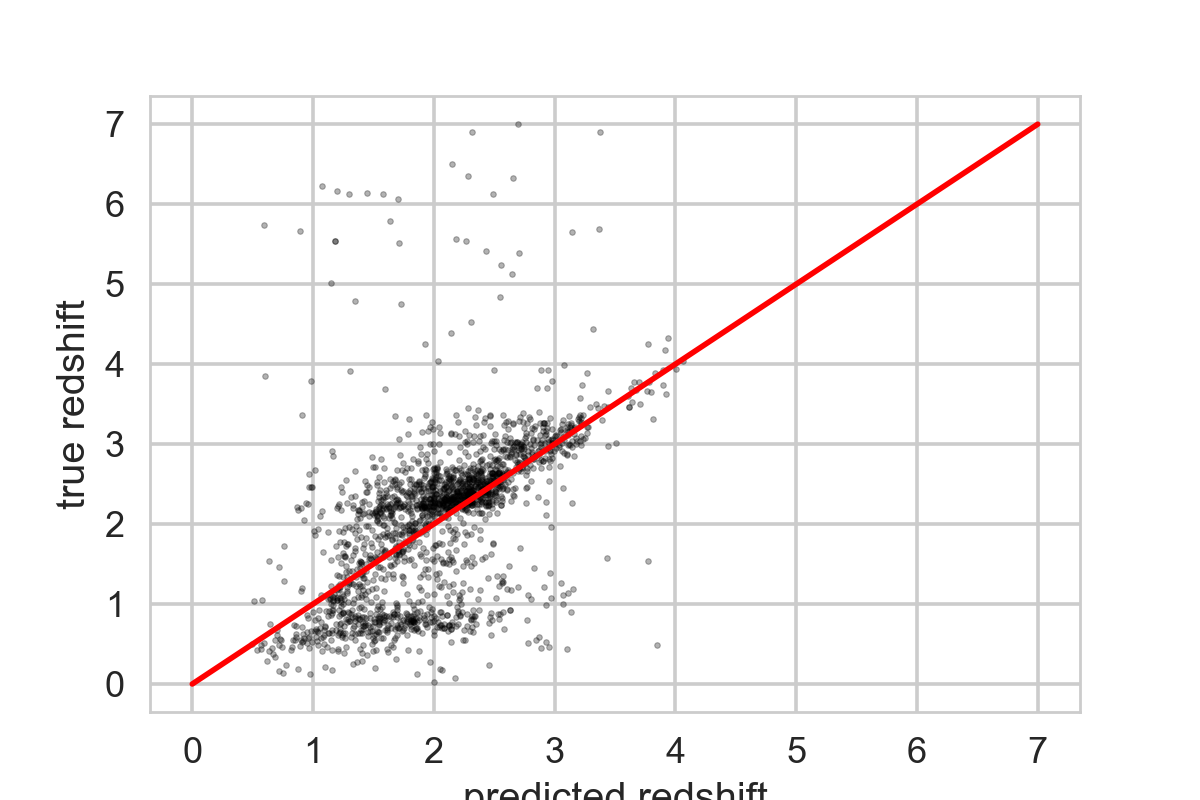

Text(0,0.5,'true redshift')

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(z_val_pred, z_val, s=4, color="black", alpha=0.3)

x = np.linspace(0,7,1000)
ax.plot(x, x, lw=2, color="red")

ax.set_xlabel("predicted redshift")
ax.set_ylabel("true redshift")

That still doesn't look great, but it looks better. :) 

### The Last Step: Evaluating Performance On Your Test Set

This is your final step: evaluate your performance on your test set! This asks many of the same questions as above: how good are your predictions? Which parts of feature space do they do well, which part of feature space do they fail? 

**Exercise**: Using your test set, evaluate how well your final, best model does. This is where you're going to need to make plots again. How well does your classifier work? Which parts of feature space does it work well on, which parts of feature space doesn't it? 

### Regression Groups Only:

Load the shared test set in `sdss_test_qsos.csv` and evaluate your performance on 
that test set. Where does your model do well? Where does it fail? Can you think 
about reasons why it might have done well or badly?

**Hint**: Make sure you do the same steps to your test data set as to your training data set (remove the same columns, make sure there are no funny values in there, and if you've scaled your features, scale the ones here, too!)

In [119]:
sdss_test = pd.read_csv("sdss_test_qsos.csv", index_col=0)

In [120]:
z_test = sdss_test["spec_z"]

In [121]:
sdss_test.columns

Index(['objid', 'ra', 'dec', 'dered_u', 'dered_g', 'dered_r', 'dered_i',
       'dered_z', 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'spec_z',
       'u_g_color', 'g_r_color', 'r_i_color', 'i_z_color', 'class', 'diff_u',
       'diff_g', 'diff_r', 'diff_i', 'diff_z'],
      dtype='object')

In [130]:
f_test = sdss_test.drop(["objid", "ra", "dec", 'mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z',
                         'class', 'diff_u','diff_g', 'diff_r', 'diff_i', 'diff_z',  'spec_z',], axis=1)

Note that we need to *transform* the features of this data set the same

In [131]:
f_test_scaled = scaler.transform(f_test)

In [135]:
rf.score(f_test_scaled, z_test)

0.33826635007325656

In [136]:
z_test_pred = rf.predict(f_test_scaled)

<IPython.core.display.Javascript object>


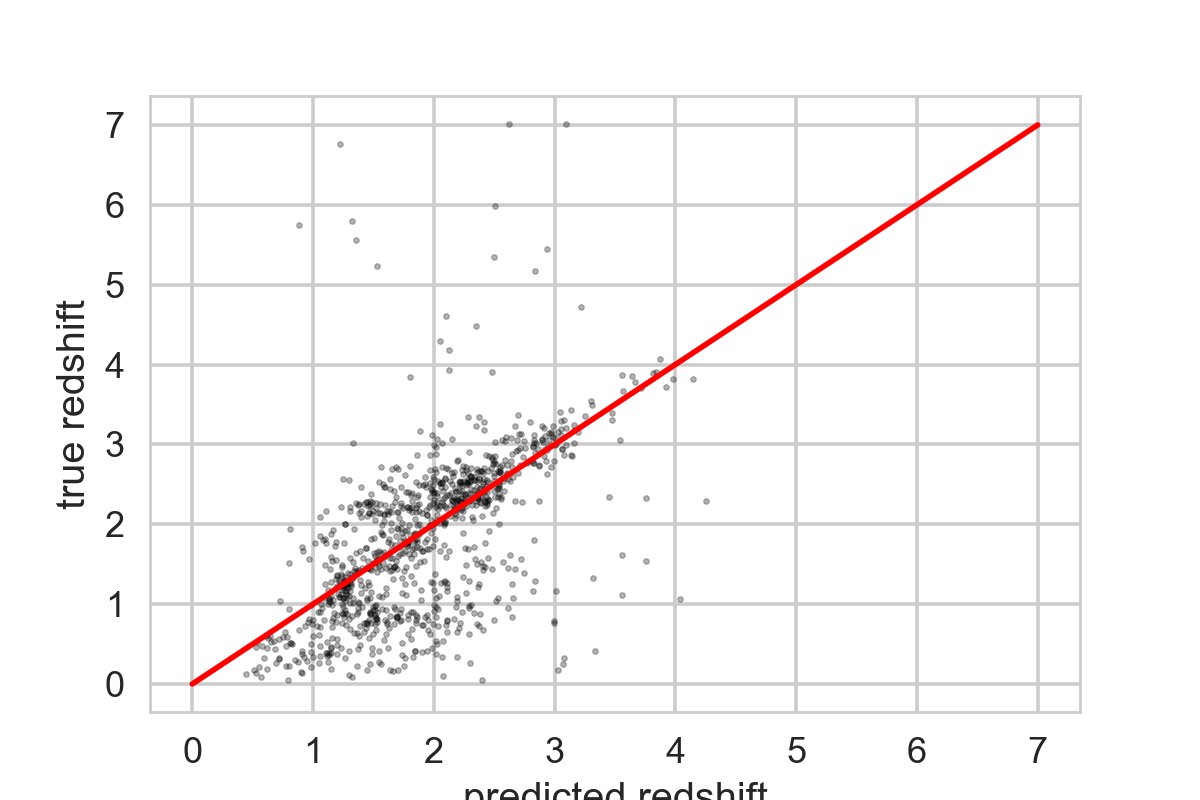

Text(0,0.5,'true redshift')

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(z_test_pred, z_test, s=4, color="black", alpha=0.3)

x = np.linspace(0,7,1000)
ax.plot(x, x, lw=2, color="red")

ax.set_xlabel("predicted redshift")
ax.set_ylabel("true redshift")

### Share Results

**Exercise**: Share results with the other groups doing a similar analysis. Did you get similar results? What did you do similarly or differently? 

**Result**: The first four data sets are different parts of the same catalogue. But 

## Advanced

There are many things we didn't get to in this tutorial that can be important for building a good machine learning analysis. Here are some ideas for what to explore next:
* **Pipelines**: scikit-learn allows it to string several algorithms together in a *pipeline*, for example a PCA transform of some features with a Random Forest Classifier. This can make it easier to cross-validate choices made during the initial feature engineering stage. Try out stringing together some algorithsm
* **Write your own class**: Scikit-learn comes with easy templates for writing your own transforms or algorithms. This can be especially useful again when feature engineering. Try to write some way of transforming your data into a transform class and include it in your pipeline!
* Explore scoring functions (`sklearn.metrics`) and Receiver Operating Curves (ROC) curves for further study!